# About dataset
This is a list of over 34,000 consumer reviews for Amazon products like the Kindle, Fire TV Stick, and more provided by Datafiniti's Product Database. The dataset includes basic product information, rating, review text, and more for each product.

To discover insights into consumer reviews and explorative data analysis of reviews. Trying to answer questions related to sentiment anaylsis and other questions such as most reviewed Amazon products? current number of customer reviews for each product? etc...



In [473]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import math
import missingno as msno
from wordcloud import WordCloud
from textwrap import wrap
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import wordnet, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error

In [ ]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [4]:
cd Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [439]:
# load the file
reviews_raw = pd.read_csv('datasets/1429_1.csv')
reviews_raw.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [440]:
reviews_raw.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

In [441]:
# required columns are considered
reviews_df=reviews_raw[['name','reviews.text','reviews.doRecommend','reviews.numHelpful', 'reviews.rating']]
reviews_df.head()

,name,reviews.text,reviews.doRecommend,reviews.numHelpful,reviews.rating
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",This product so far has not disappointed. My c...,True,0.0,5.0
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",great for beginner or experienced person. Boug...,True,0.0,5.0
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Inexpensive tablet for him to use and learn on...,True,0.0,5.0
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I've had my Fire HD 8 two weeks now and I love...,True,0.0,4.0
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I bought this for my grand daughter when she c...,True,0.0,5.0


In [442]:
# column data types
reviews_df.dtypes

name                    object
reviews.text            object
reviews.doRecommend     object
reviews.numHelpful     float64
reviews.rating         float64
dtype: object

In [443]:
reviews_df.describe()

,reviews.numHelpful,reviews.rating
count,34131.000000,34627.000000
mean,0.630248,4.584573
std,13.215775,0.735653
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,5.000000
75%,0.000000,5.000000
max,814.000000,5.000000


# Data cleansing

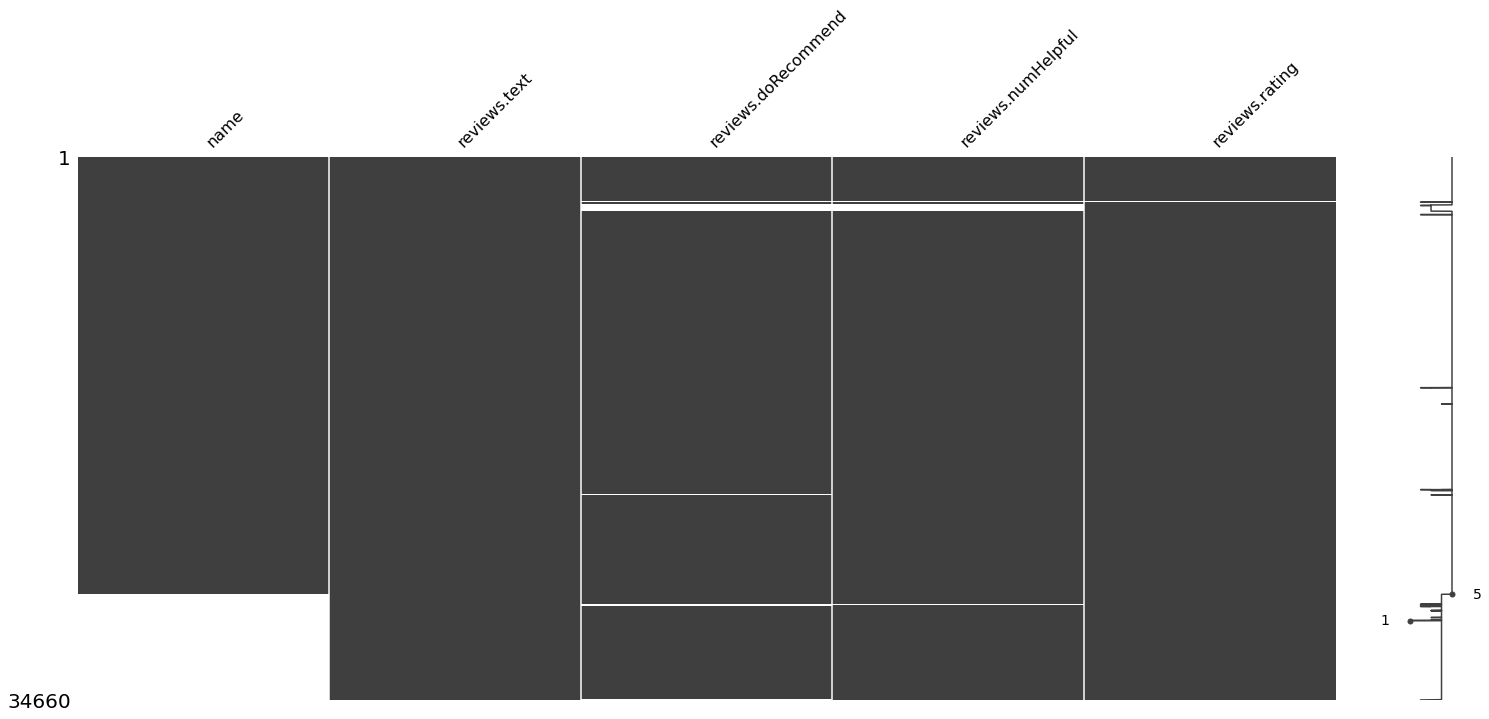

In [444]:
msno.matrix(reviews_df);

In [445]:
print('% of missing values compared to total datapoints')
round(reviews_df.isnull().sum()/len(reviews_df) * 100, 2)

% of missing values compared to total datapoints


name                   19.50
reviews.text            0.00
reviews.doRecommend     1.71
reviews.numHelpful      1.53
reviews.rating          0.10
dtype: float64

Since the missing values percent is low, the rows are dropped

In [446]:
reviews_df.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


name                   False
reviews.text           False
reviews.doRecommend    False
reviews.numHelpful     False
reviews.rating         False
dtype: bool

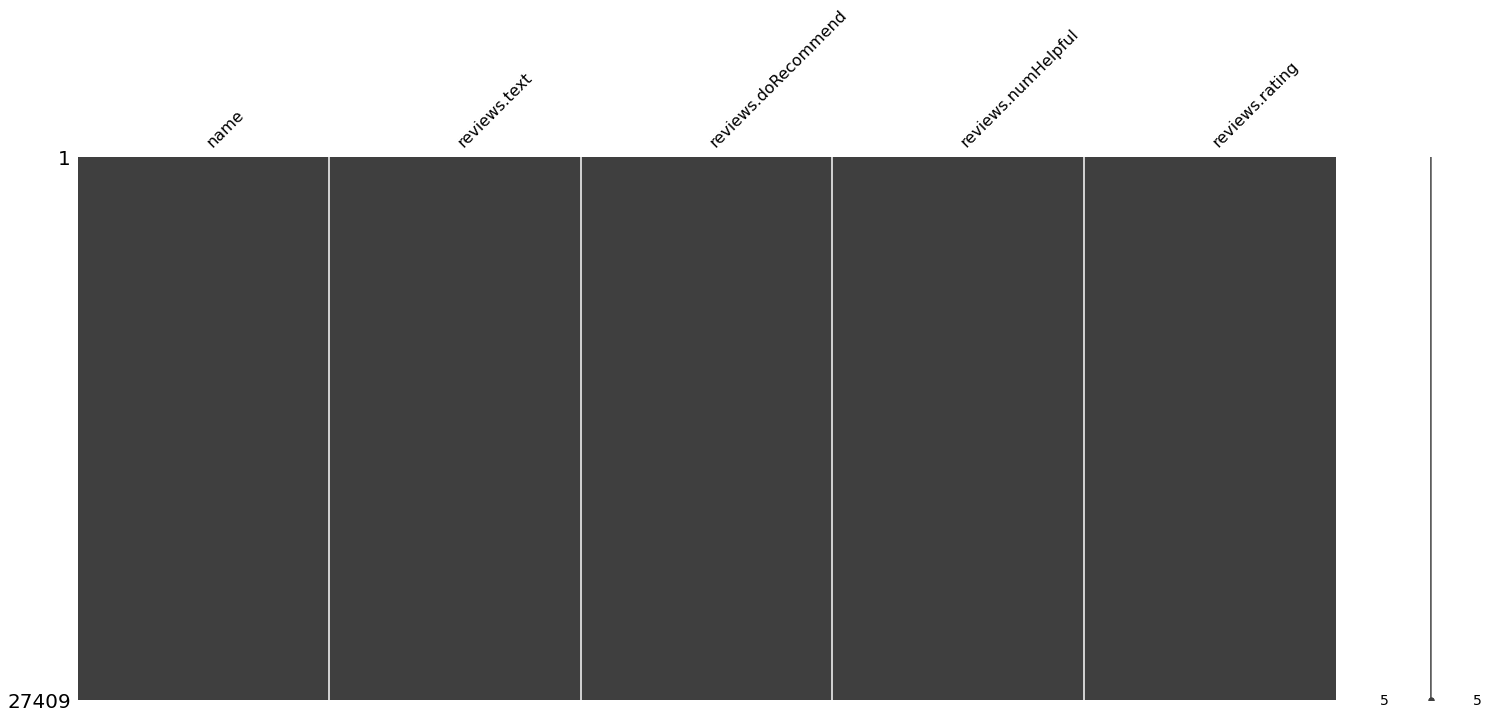

In [447]:
msno.matrix(reviews_df);
reviews_df.isnull().any()

In [448]:
# consider products with reviews greater than 500
df = reviews_df.groupby('name').filter(lambda x : len(x)>500).reset_index(drop=True)

In [449]:
print('Unique products in the data are : \n', df.name.unique())

Unique products in the data are : 
 ['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta'
 'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta'
 'Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,,,'
 'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case'
 'Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,'
 'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers,'
 'Echo (White),,,\r\nEcho (White),,,'
 'Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,']


In [450]:
# since they are float, convert to int
df['reviews.doRecommend']=df['reviews.doRecommend'].astype(int)
df['reviews.numHelpful']=df['reviews.numHelpful'].astype(int)

In [451]:
# some names have ',,,'. so remove them
df['name'] = df['name'].apply(lambda x: x.split(',,,')[0])

In [452]:
df['name'].unique()

array(['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta',
       'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta',
       'Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue',
       'Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case',
       'Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black',
       'Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers,',
       'Echo (White)', 'Amazon Fire Tv'], dtype=object)

In [453]:
# glance of review text
for index, text in enumerate(df['reviews.text'][:15]):
  print('Review {} :\n {}'.format(index+1, text))

Review 1 :
 This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.
Review 2 :
 great for beginner or experienced person. Bought as a gift and she loves it
Review 3 :
 Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...
Review 4 :
 I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime content as well as movies you can download and watch laterThis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the ipad pro costing $900 base model. The build on this fire is INSANELY AWESOME running at only 7.7mm thick and the smooth glossy feel on the back it is really amazing to hold its like the futuristic tab in ur hands.
Review

# Data pre-processing

In [454]:
# lower case
df['cleaned']=df['reviews.text'].apply(lambda x: x.lower())

# Remove digits and words containing digits
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

# Remove Punctuations
df['cleaned']=df['cleaned'].apply(lambda x: re.sub("["+string.punctuation+"]", " ", x))

# Remove numerical 
df['cleaned']=df['cleaned'].apply(lambda x: re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", x))

special_char_map = {ord('ä'):'ae', ord('ü'):'ue', ord('ö'):'oe', ord('ß'):'ss'}
df['cleaned']=df['cleaned'].apply(lambda x: x.translate(special_char_map))

# Removing extra spaces
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

# Stopwords Removal
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join(word for word in x.split() if word not in stopwords.words('english')))

# remove words less than 3 letters
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

# lemmitized
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([word_lem.lemmatize(word, 'v') for word in x.split() ]))

In [455]:
# after cleaning
for index, text in enumerate(df['cleaned'][:10]):
  print('Review {} :\n {}'.format(index+1, text))

Review 1 :
 product disappointed children love like ability monitor control content ease
Review 2 :
 great beginner experienced person bought gift loves
Review 3 :
 inexpensive tablet learn step nabi thrilled learn skype already
Review 4 :
 fire weeks love tablet great value prime members tablet shines love able easily access prime content well movies download watch laterthis screen really nice look nice crisp bright infact brighter ipad costing base model build fire insanely awesome running thick smooth glossy feel back really amazing hold like futuristic hands
Review 5 :
 bought grand daughter comes visit user entered name amazon makes sure accesses sites content appropriate simple loves capabilities also bought installed card gives little tablet plenty storage price think tablet best spend hundreds dollars additional speed capacity comes basics tablets everything people ever need fraction cost
Review 6 :
 amazon fire inch tablet perfect size purchased husband bigger screen phone got

In [456]:
# after lemmatization
for index, text in enumerate(df['lemmatized'][:10]):
  print('Review {} :\n {}'.format(index+1, text))

Review 1 :
 product disappoint children love like ability monitor control content ease
Review 2 :
 great beginner experience person buy gift love
Review 3 :
 inexpensive tablet learn step nabi thrill learn skype already
Review 4 :
 fire weeks love tablet great value prime members tablet shin love able easily access prime content well movies download watch laterthis screen really nice look nice crisp bright infact brighter ipad cost base model build fire insanely awesome run thick smooth glossy feel back really amaze hold like futuristic hand
Review 5 :
 buy grand daughter come visit user enter name amazon make sure access sit content appropriate simple love capabilities also buy instal card give little tablet plenty storage price think tablet best spend hundreds dollars additional speed capacity come basics tablets everything people ever need fraction cost
Review 6 :
 amazon fire inch tablet perfect size purchase husband bigger screen phone get years know would good purchase
Review 7 :

Number of reviews per unique product

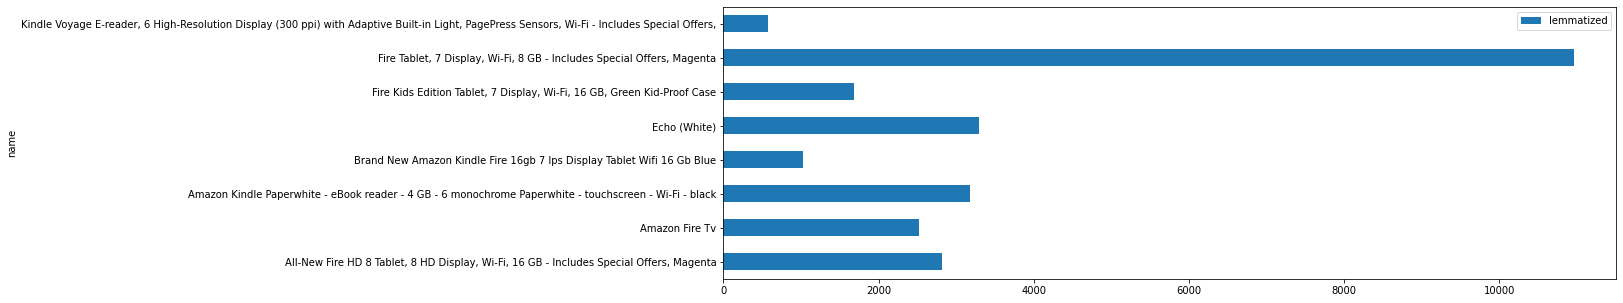

In [457]:
df[['name','lemmatized']].groupby(by='name').agg('count').plot(kind='barh', figsize=(16, 5));

In [458]:
# join all the reviews product wise
product_grouped = df[['name','lemmatized']].groupby(by='name').agg(lambda x:' '.join(x))
product_grouped

,lemmatized
name,
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",product disappoint children love like ability ...
Amazon Fire Tv,echo learn everyday use daily place speaker co...
Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,nice little slow wish would investigate little...
Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,best value money hand work perfectly purchase ...
Echo (White),although compete ipad higher android tablets e...
"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",tablet light stream well stream movies much li...
"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",sales people really nice knowledgeable come ba...
"Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers,",much better original kindle lighter easier rea...


In [459]:
# Creating Document Term Matrix
cv=CountVectorizer(analyzer='word')

## fit the data
data=cv.fit_transform(df_grouped['lemmatized'])

# create a dataframe
dtm_df = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
dtm_df.index=df_grouped.index
dtm_df.head()

,abilities,ability,abke,able,absent,absolute,absolutely,absorb,abuse,accent,accept,acceptable,access,accessories,accessory,accident,accidentally,accidently,accidents,accommodate,accompany,accomplish,accord,account,accurate,accurately,acquire,across,act,action,activate,activation,active,activities,actual,actually,adapt,adapter,add,addict,...,yard,yeah,year,years,yell,yesterday,you,youand,youll,young,younger,youngest,youngsters,youth,youtube,zero,zigbee,zinio,zone,äãis,äî,äîand,äîbadly,äîespecially,äôd,äôll,äôm,äôre,äôs,äôt,äôve,äù,äùcrestron,äúalexa,äúbest,äúdropping,äúshow,äúskills,äústar,äúthings
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",1,9,0,21,0,1,7,0,1,0,1,0,18,0,0,0,0,0,0,0,0,1,0,9,0,0,0,1,0,2,0,0,0,1,1,5,0,0,4,0,...,0,0,41,18,0,1,0,1,0,2,2,2,0,1,9,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Amazon - Echo Plus w/ Built-In Hub - Silver,0,6,0,31,0,0,12,0,0,1,0,1,2,2,0,0,0,0,0,0,0,0,1,5,1,1,1,2,1,0,3,1,0,0,1,1,2,0,22,1,...,1,1,7,2,1,2,1,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,4,10,1,34,33,9,4,1,2,0,0,0,0,0,1
"Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",1,12,0,66,1,1,11,0,0,0,0,0,6,1,3,0,0,0,0,1,1,0,0,8,2,0,0,5,0,3,4,0,1,1,0,16,0,1,30,1,...,0,1,18,6,1,0,4,0,1,0,1,2,0,0,37,1,0,0,0,0,1,2,1,1,3,2,22,5,58,38,7,9,0,3,1,1,1,1,2,1
"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",0,6,1,24,0,0,11,1,2,0,0,0,24,0,0,1,2,1,1,0,0,0,0,18,0,0,0,0,0,0,1,0,0,3,0,4,0,0,2,0,...,0,0,131,21,0,0,0,0,0,11,2,1,1,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


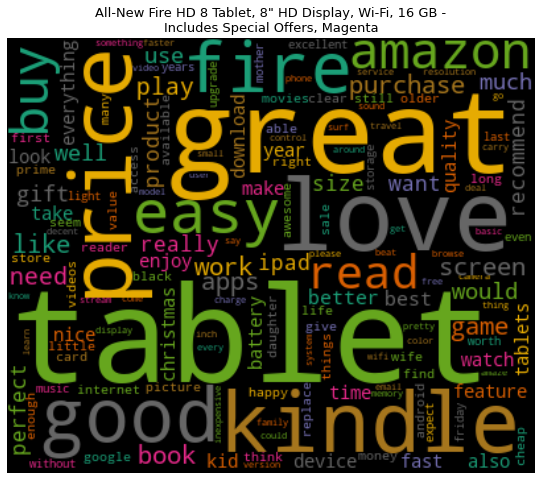

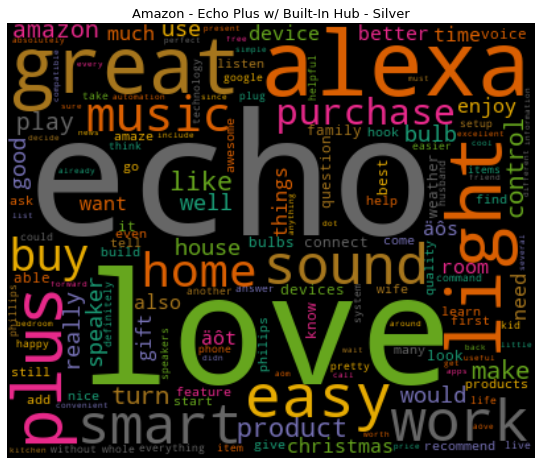

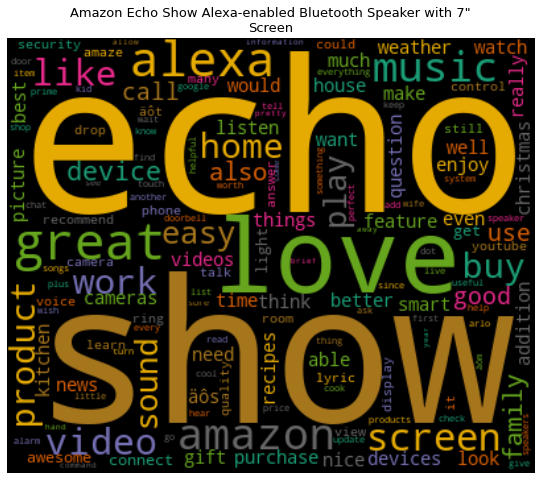

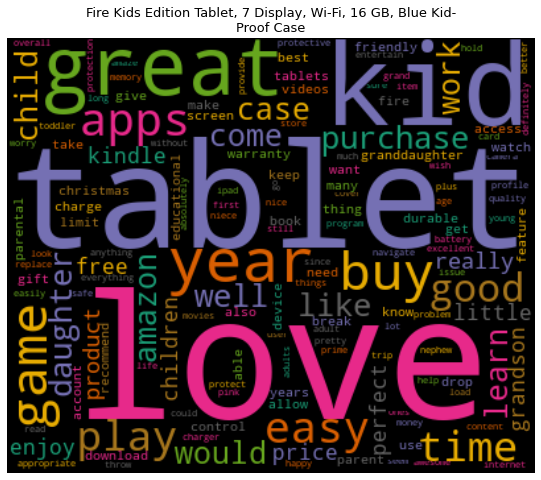

In [460]:
# plotting words in reviews with word clouds 

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
dtm_df=dtm_df.transpose()

# Plotting word cloud for each product
for index,product in enumerate(dtm_df.columns):
  generate_wordcloud(dtm_df[product].sort_values(ascending=False),product)

In [461]:
# sentiment analysis of the reviews for each product
from textblob import TextBlob
df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [462]:
print("Random Reviews with Highest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[:2].index]['reviews.text']):
  print('Review {}:\n'.format(index+1),review)

Random Reviews with Highest Polarity:
Review 1:
 There is nothing else I can say about this product except that it is an excellent gadget to have around the house. You want to hear music, have a question about the weather, Trivia, sports, etc. Just ask Alexa.
Review 2:
 I bought this as a gift and it has performed perfectly. Can't beat at this price.


In [464]:
print("Random Reviews with lowest Polarity:")
for index, review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[-2:].index]['reviews.text']):
  print('Review {} : \n '.format(index+1), review)

Random Reviews with lowest Polarity:
Review 1 : 
  Bought it so my son would stop grabbing for my phone. Does what it needs to but battery life is horrible
Review 2 : 
  One of the worst purchases or investments you could make for technology.


# sentiment (polarity) for different products considereing all rerviews

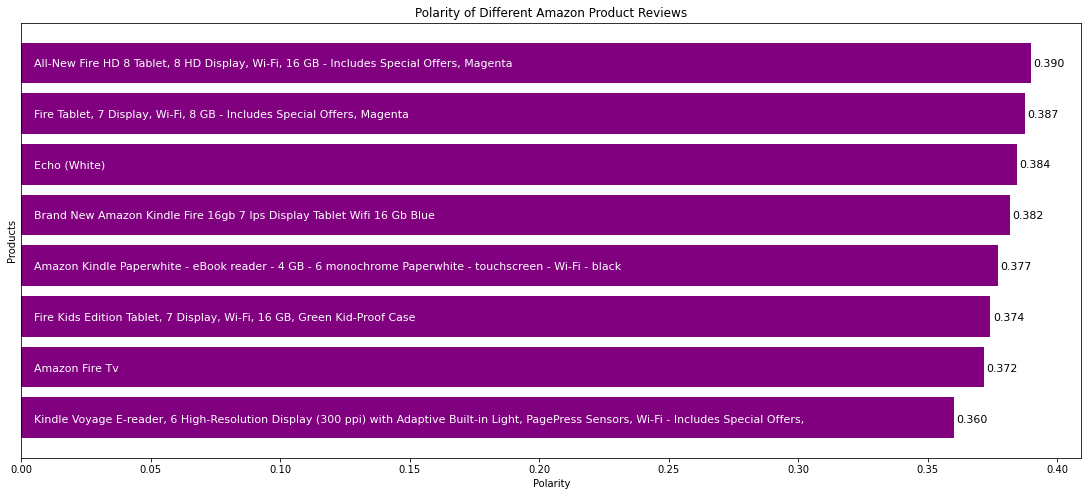

In [497]:
# df sorted
product_polarity_sorted = pd.DataFrame(df.groupby('name')['polarity'].mean().sort_values(ascending=True))

# plot
plt.figure(figsize=(19,8))
plt.xlabel('Polarity')
plt.ylabel('Products')
plt.title('Polarity of Different Amazon Product Reviews')

polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

how much the products are been recommended

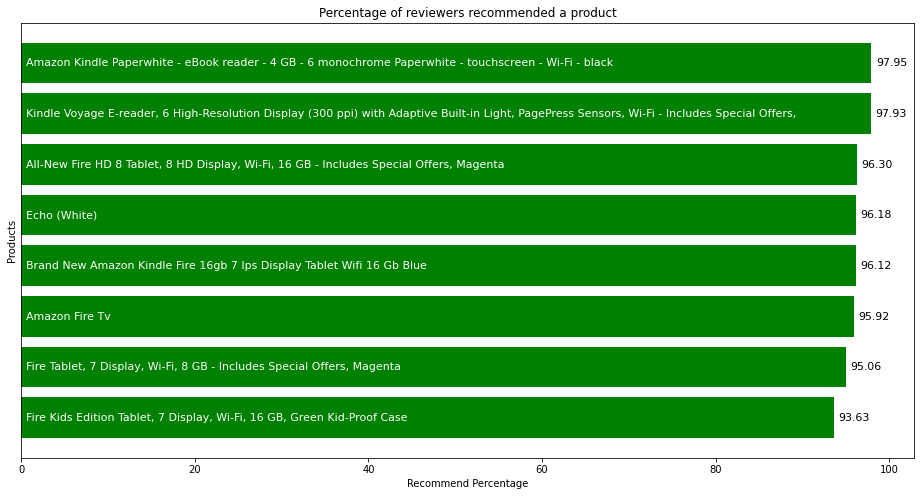

In [470]:
#
recommend_percentage=pd.DataFrame(((df.groupby('name')['reviews.doRecommend'].sum()*100)/df.groupby('name')['reviews.doRecommend'].count()).sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Recommend Percentage')
plt.ylabel('Products')
plt.title('Percentage of reviewers recommended a product')
recommend_graph=plt.barh(np.arange(len(recommend_percentage.index)),recommend_percentage['reviews.doRecommend'],color='green')

# Writing product names on bar
for bar,product in zip(recommend_graph,recommend_percentage.index):
  plt.text(0.5,bar.get_y()+0.4,'{}'.format(product),va='center',fontsize=11,color='white')

# Writing recommendation percentage on graph
for bar,percentage in zip(recommend_graph,recommend_percentage['reviews.doRecommend']):
  plt.text(bar.get_width()+0.5,bar.get_y()+0.4,'%.2f'%percentage,va='center',fontsize=11,color='black')

plt.yticks([])
plt.show()

# Sentiment analysis



In [480]:
# convert labels to 3 categories of sentiment
df['label'] = df['reviews.rating'].apply(lambda x: 'positive' if x > 3 else ('neutral' if x==3 else 'negative'))
df['label'].value_counts()

positive    24247
neutral      1221
negative      600
Name: label, dtype: int64

In [481]:
# tf-idf for ML algorithm
tfidf_vectorizer = TfidfVectorizer(max_df=0.90,stop_words='english')

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['cleaned'])

In [484]:
# split the data into train, valid and test
size = 0.15
index = int(size * tfidf.shape[0])

train=tfidf[:index]
train_label=df['label'][:index]

test =tfidf[index:]
test_label =df['label'][index:] 

X_train, X_valid, y_train, y_valid = train_test_split(train, train_label, random_state=42, test_size=0.25)
print('Train-valid-test split is done')

Train-valid-test split is done


In [485]:
# LR with weight balanced for classes to tackle imbalance
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [489]:
# predict on valid set
valid_predict = lr.predict(X_valid) 

In [493]:
print('-'*15, 'confusion matrix report', '-'*15,'\n')
print(sklearn.metrics.confusion_matrix(y_valid, valid_predict))
print('-'*15, 'Classification report', '-'*15,'\n')
print(sklearn.metrics.classification_report(y_valid, valid_predict, digits=3))

--------------- confusion matrix report --------------- 

[[  4   4   8]
 [  5   9  30]
 [ 17  41 860]]
--------------- Classification report --------------- 

              precision    recall  f1-score   support

    negative      0.154     0.250     0.190        16
     neutral      0.167     0.205     0.184        44
    positive      0.958     0.937     0.947       918

    accuracy                          0.893       978
   macro avg      0.426     0.464     0.440       978
weighted avg      0.909     0.893     0.900       978



### Test set

In [496]:
# predict on test set
predict = lr.predict(test) 
print('-'*15, 'confusion matrix report', '-'*15,'\n')
print(sklearn.metrics.confusion_matrix(test_label, predict))
print('-'*15, 'Classification report', '-'*15,'\n')
print(sklearn.metrics.classification_report(test_label, predict, digits=3))

--------------- confusion matrix report --------------- 

[[  115   133   269]
 [   68   225   761]
 [  256  1043 19288]]
--------------- Classification report --------------- 

              precision    recall  f1-score   support

    negative      0.262     0.222     0.241       517
     neutral      0.161     0.213     0.183      1054
    positive      0.949     0.937     0.943     20587

    accuracy                          0.886     22158
   macro avg      0.457     0.458     0.456     22158
weighted avg      0.896     0.886     0.891     22158

